In [1]:
%load_ext autoreload
%autoreload 2

# Online Outcomes: Predicting Success in Virtual Learning

**<font size="4">Author: Jeffrey Hanif Watson</font>**

## Imports and Project Path

In [2]:
# importing packages
import os, sys, glob, re
import pandas as pd
import numpy as np
import sqlite3

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import functions as fn
from src import visualizations as vz

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette("winter_r")
pd.options.display.max_rows = 300

## Creating SQL Database

**<font size="3">This cell can be run once to establish the database and then commented out.</font>**

In [3]:
# # creating and populating database
# file_name = 'anonymisedData.zip'
# database_name = 'outcomes.db'
# fn.db_create(file_name, database_name)

## Database ERD

![graph0](../../references/schema.png)

## EDA

### SQL Setup
Connecting to database and creating a cursor object.

In [4]:
# creating connection, and cursor
data_path = os.path.join(gparent,'data/processed','outcomes.db')
conn = sqlite3.connect(data_path)  
cur = conn.cursor()

### Checking table names

In [5]:
# checking the table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fn.fetch(cur, q)

[('ASSESSMENTS',),
 ('COURSES',),
 ('STUDENTASSESSMENT',),
 ('STUDENTINFO',),
 ('STUDENTREGISTRATION',),
 ('STUDENTVLE',),
 ('VLE',)]

## Data Understanding

### Codes & Module Summaries

In [6]:
# month codes used in code_presentation
month_codes = {
    'A': 'January', 
    'B': 'Februrary',
    'C': 'March', 
    'D': 'April',
    'E': 'May',
    'F': 'June',
    'G': 'July',
    'H': 'August',
    'I': 'Septemeber',
    'J': 'October',
    'K': 'November',
    'L': 'December'
        }

In [7]:
# module codes and summaries
module_codes = {
    'AAA': {'Domain': 'Social Sciences', 'Presentations': 2, 'Students': 748},
    'BBB': {'Domain': 'Social Sciences', 'Presentations': '4', 'Students': 7909},
    'CCC': {'Domain': 'STEM', 'Presentations': 2, 'Students': 4434},
    'DDD': {'Domain': 'STEM', 'Presentations': 4, 'Students': 6272},
    'EEE': {'Domain': 'STEM', 'Presentations': 3, 'Students': 2934},
    'FFF': {'Domain': 'STEM', 'Presentations': 4, 'Students': 7762},
    'GGG': {'Domain': 'Social Sciences', 'Presentations': 3, 'Students': 2534}
}

In [8]:
# checking work
print('Students')
print('---------')
for key in module_codes.keys():
    print(key, module_codes[key]['Students'])

Students
---------
AAA 748
BBB 7909
CCC 4434
DDD 6272
EEE 2934
FFF 7762
GGG 2534


### Creating Data Frames

### Student Info Data Frame

In [9]:
# creating student_info dataframe and appending column names
q = "SELECT*FROM STUDENTINFO"
student_info = pd.DataFrame(fn.fetch(cur, q))
student_info.columns = [i[0] for i in cur.description]

In [10]:
# checking first five rows
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [11]:
# checking info
student_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  object
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  object
 9   studied_credits       32593 non-null  object
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: object(12)
memory usage: 3.0+ MB


In [12]:
# checking for nulls
student_info.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

We have 1100 null values in the imd_band column. We'll drop them for now.

In [83]:
# dropping nulls
student_info.dropna(inplace=True)

In [84]:
# checking work
student_info.isna().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64

In [15]:
# checking new shape
student_info.shape

(31482, 12)

### Outcomes By Types

In [16]:
student_info.final_result.value_counts(normalize=True)

Pass           0.375770
Withdrawn      0.315101
Fail           0.219395
Distinction    0.089734
Name: final_result, dtype: float64

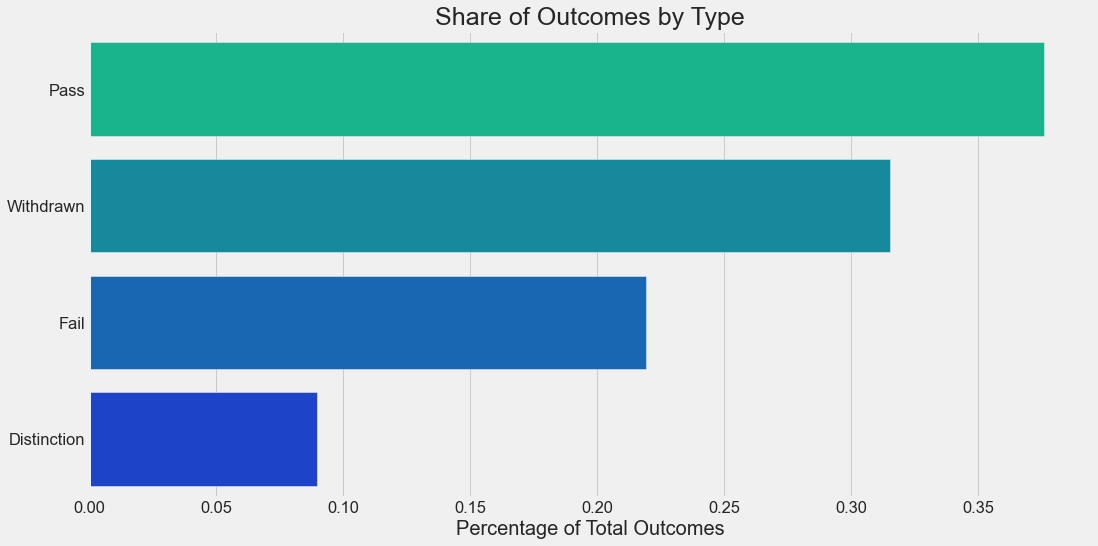

In [17]:
vz.outcomes_type(student_info)

### Outcomes By IMD Band

In [18]:
student_info['imd_band'].unique()

array(['90-100%', '20-30%', '30-40%', '50-60%', '80-90%', '70-80%',
       '60-70%', '40-50%', '10-20', '0-10%'], dtype=object)

In [19]:
student_info['imd_band'].value_counts(normalize=True)

20-30%     0.116066
30-40%     0.112413
10-20      0.111683
0-10%      0.105171
40-50%     0.103424
50-60%     0.099231
60-70%     0.092275
70-80%     0.091449
80-90%     0.087733
90-100%    0.080554
Name: imd_band, dtype: float64

In [20]:
# fixing typo
student_info['imd_band'] = student_info['imd_band'].replace(['10-20'], '10-20%')

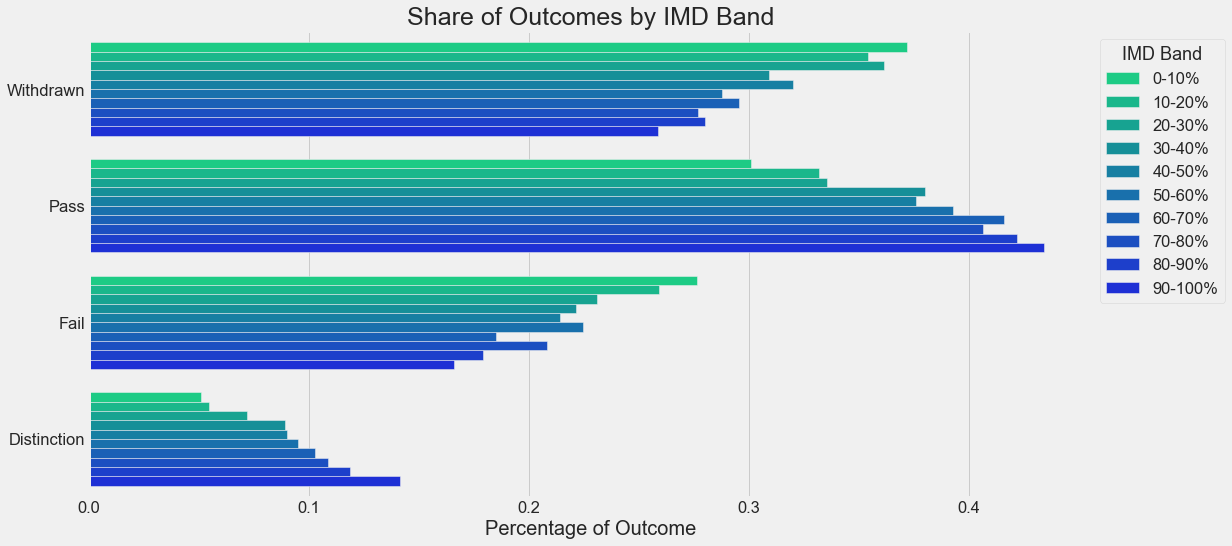

In [21]:
vz.outcomes_imd(student_info)

### Outcomes By Disability Status

In [22]:
student_info['disability'].value_counts(normalize=True)

N    0.900546
Y    0.099454
Name: disability, dtype: float64

In [23]:
# renaming values
student_info['disability'] = student_info['disability'].replace(['Y', 'N'], ['Yes', 'No'])

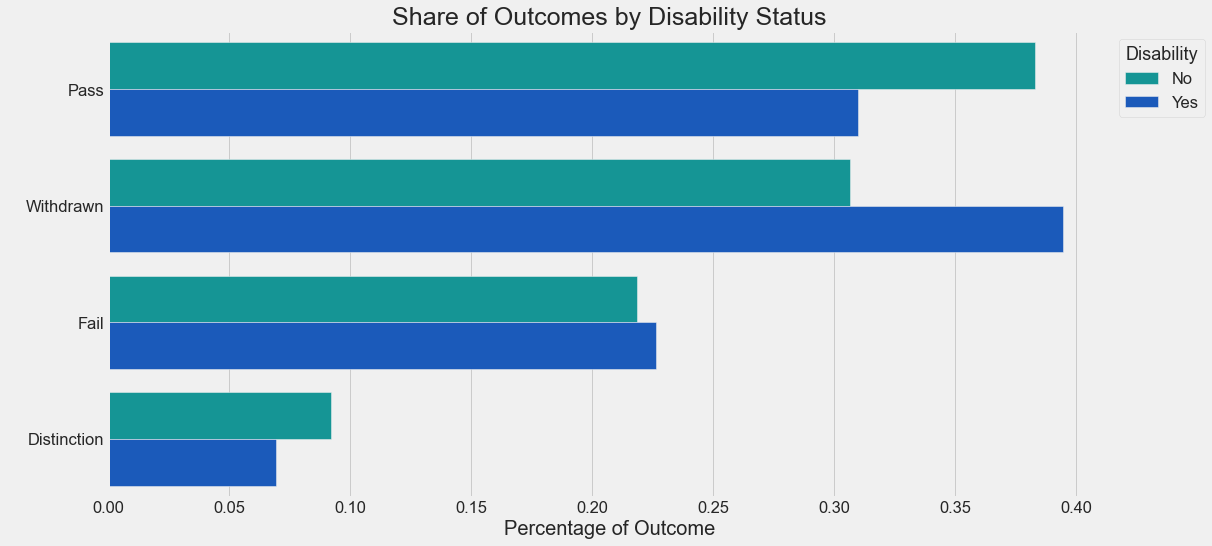

In [24]:
vz.outcomes_dis(student_info)

### Outcomes By Age Band

In [25]:
student_info.age_band.value_counts(normalize=True)

0-35     0.707452
35-55    0.286164
55<=     0.006385
Name: age_band, dtype: float64

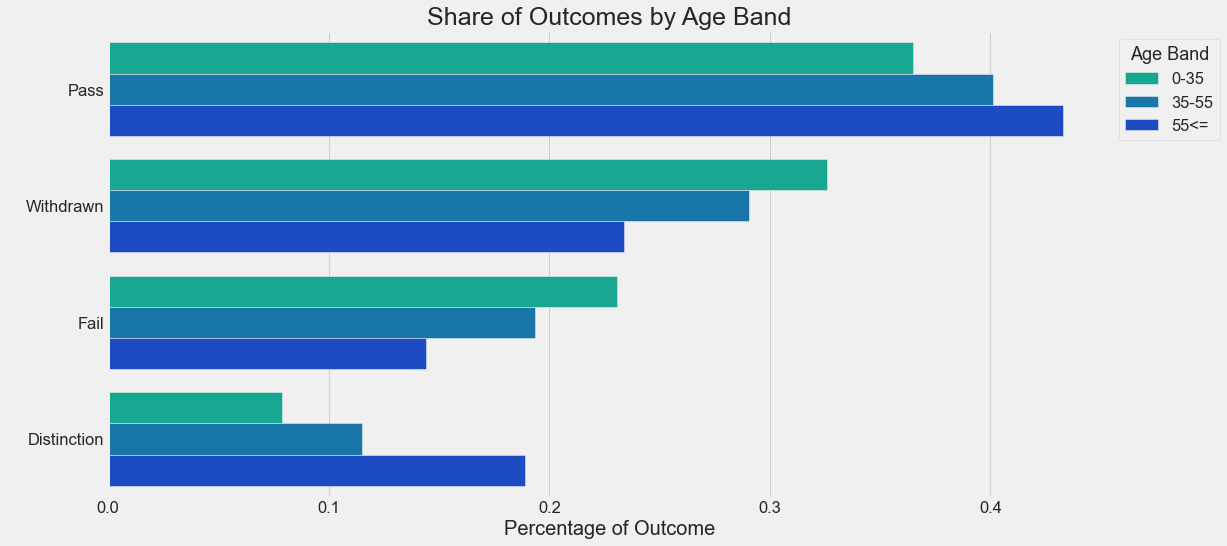

In [26]:
vz.outcomes_age(student_info)

### Outcomes By Education Level

In [27]:
student_info.highest_education.value_counts(normalize=True)

A Level or Equivalent          0.437139
Lower Than A Level             0.405374
HE Qualification               0.141160
No Formal quals                0.010419
Post Graduate Qualification    0.005908
Name: highest_education, dtype: float64

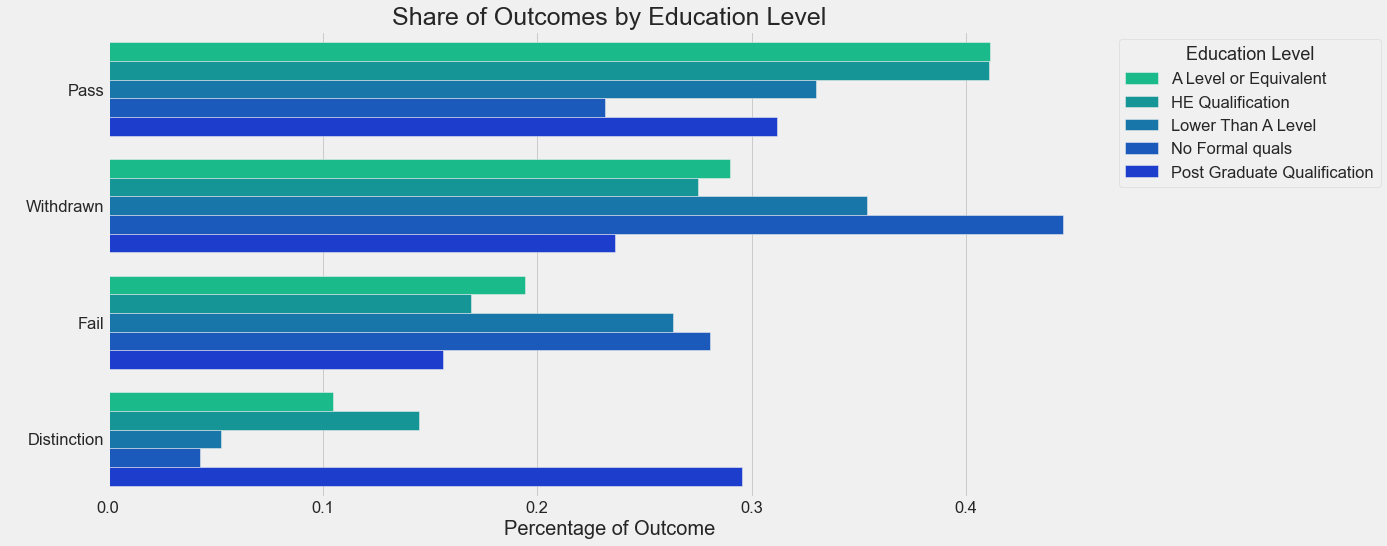

In [28]:
vz.outcomes_edu(student_info)

### Outcomes By Gender

In [29]:
student_info.gender.value_counts(normalize=True)

M    0.542119
F    0.457881
Name: gender, dtype: float64

In [30]:
# renaming values
student_info['gender'] = student_info['gender'].replace(['M', 'F'], ['Male', 'Female'])

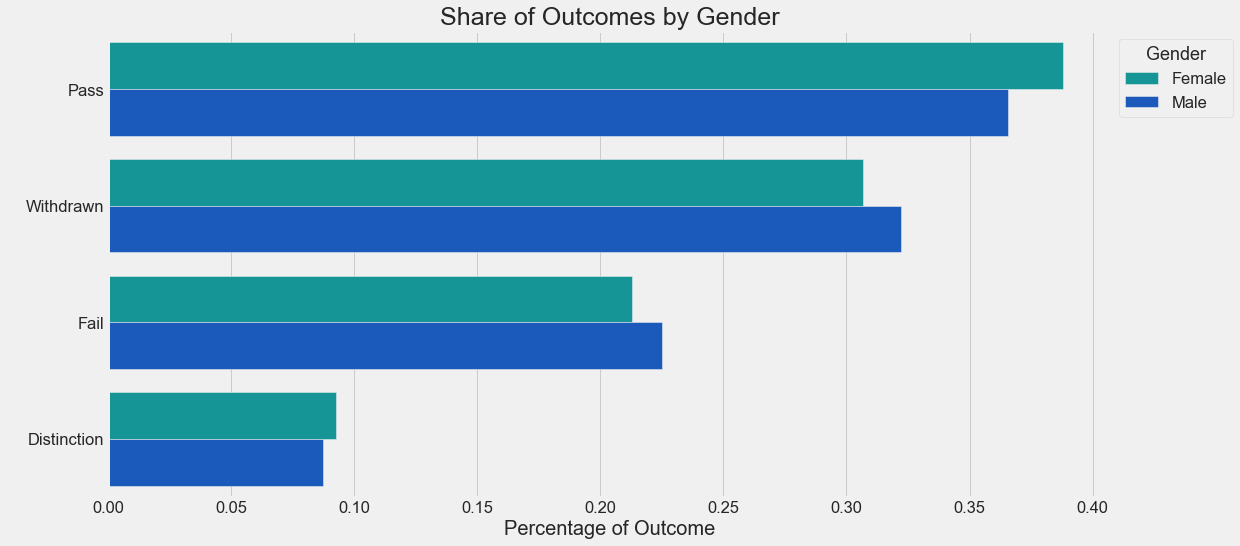

In [31]:
vz.outcomes_gen(student_info)

### Outcomes by Region

In [34]:
student_info.region.value_counts(normalize=True)

Scotland                0.109078
East Anglian Region     0.106092
London Region           0.102154
South Region            0.096690
North Western Region    0.092148
West Midlands Region    0.080776
South West Region       0.077219
East Midlands Region    0.075122
South East Region       0.067054
Wales                   0.066260
Yorkshire Region        0.063560
North Region            0.034686
Ireland                 0.029160
Name: region, dtype: float64

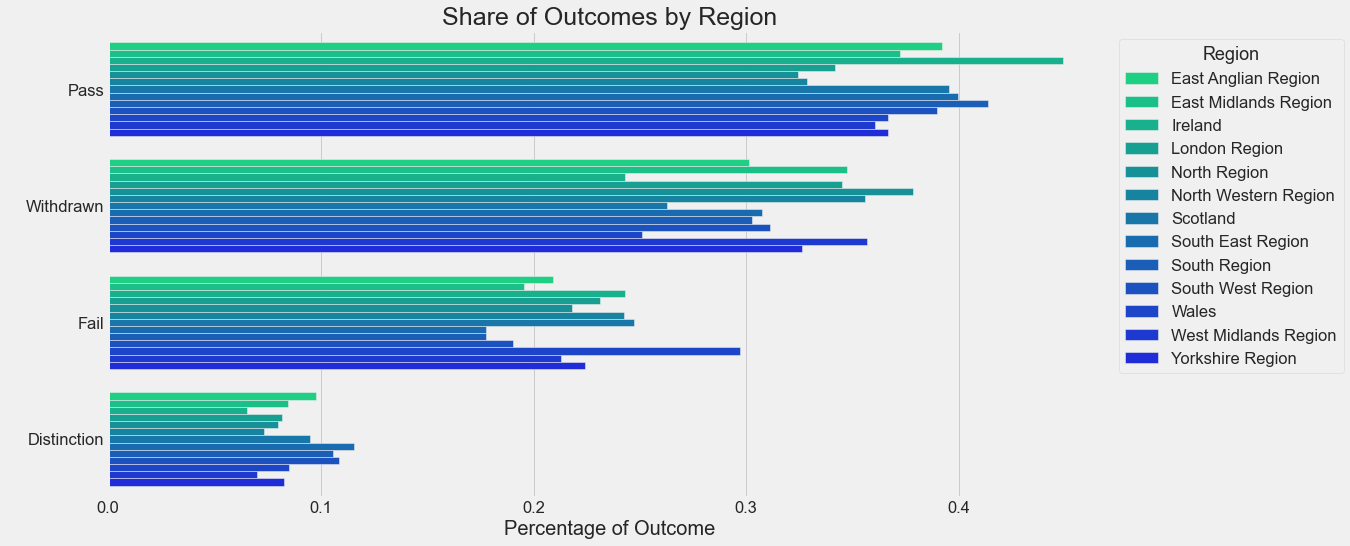

In [32]:
vz.outcomes_reg(student_info)

### Studied Credits

In [43]:
student_info['studied_credits'] = student_info['studied_credits'].map(pd.to_numeric)

In [51]:
student_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31482 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           31482 non-null  object
 1   code_presentation     31482 non-null  object
 2   id_student            31482 non-null  object
 3   gender                31482 non-null  object
 4   region                31482 non-null  object
 5   highest_education     31482 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              31482 non-null  object
 8   num_of_prev_attempts  31482 non-null  object
 9   studied_credits       31482 non-null  int64 
 10  disability            31482 non-null  object
 11  final_result          31482 non-null  object
dtypes: int64(1), object(11)
memory usage: 4.1+ MB


In [54]:
student_info.studied_credits.value_counts(normalize=True)[:10]

60     0.513214
120    0.195127
30     0.115749
90     0.095388
180    0.025729
150    0.023474
240    0.006956
210    0.005209
75     0.003431
70     0.002795
Name: studied_credits, dtype: float64

In [58]:
student_info.studied_credits.mean()

79.7678038244076

### Student VLE

In [59]:
# creating student_vle dataframe and appending column names
q = "SELECT*FROM STUDENTVLE"
student_vle = pd.DataFrame(fn.fetch(cur, q))
student_vle.columns = [i[0] for i in cur.description]

In [60]:
student_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [61]:
#  checking info
student_vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         object
 3   id_site            object
 4   date               object
 5   sum_click          object
dtypes: object(6)
memory usage: 487.8+ MB


In [62]:
# checking for nulls
student_vle.isna().sum()

code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64

In [63]:
# changing data types
student_vle[['date','sum_click']] = student_vle[['date','sum_click']].apply(pd.to_numeric)

In [64]:
# checking work
student_vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         object
 3   id_site            object
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(2), object(4)
memory usage: 487.8+ MB


#### Student 28400
Focusing on a single student to get a better feel for the data.

In [68]:
id_28400 = student_vle[student_vle['id_student']=='28400']

In [69]:
id_28400.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 174007
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   code_module        430 non-null    object
 1   code_presentation  430 non-null    object
 2   id_student         430 non-null    object
 3   id_site            430 non-null    object
 4   date               430 non-null    int64 
 5   sum_click          430 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [70]:
len(id_28400.id_site.unique())

84

In [71]:
id_28400.code_module.unique()

array(['AAA'], dtype=object)

In [72]:
id_28400.sum_click.sum()

1435

In [73]:
date_sorted = id_28400.sort_values(by=['date']).reset_index(drop=True)

In [74]:
date_sorted.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546871,-10,3
2,AAA,2013J,28400,547013,-10,1
3,AAA,2013J,28400,547011,-10,1
4,AAA,2013J,28400,546890,-10,1


In [75]:
date_clix = pd.DataFrame(id_28400.groupby('date')['sum_click'].sum()).reset_index()

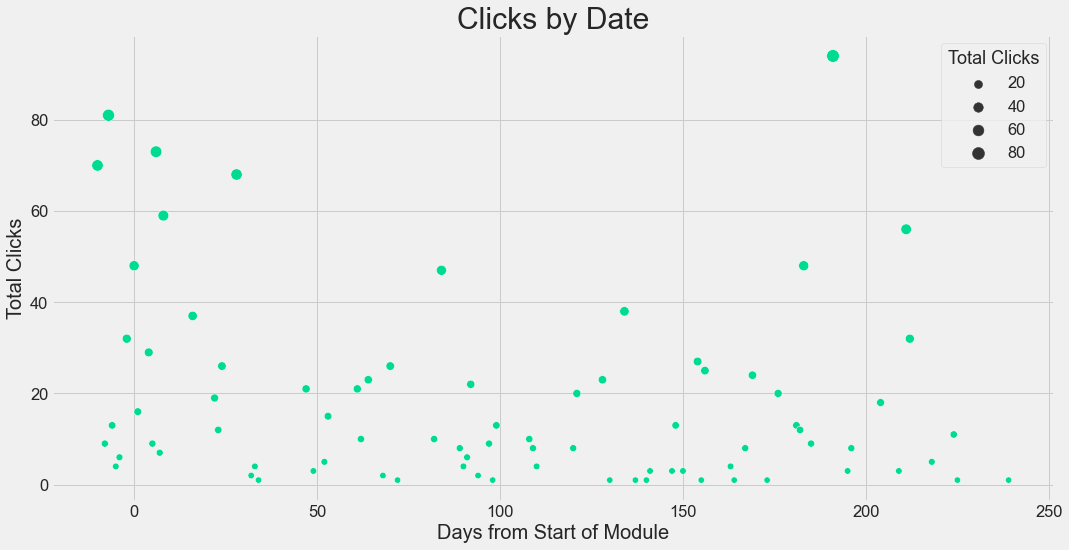

In [76]:
fig, ax=plt.subplots(figsize=(16,8))
sns.scatterplot(x='date', y='sum_click', size='sum_click', data=date_clix)
plt.title('Clicks by Date', fontsize=30)
plt.legend(title='Total Clicks')
plt.ylabel('Total Clicks', fontsize=20)
plt.xlabel('Days from Start of Module', fontsize=20)
plt.show()

### VLE

In [77]:
q='SELECT*FROM VLE'
vle =pd.DataFrame(fn.fetch(cur,q))
vle.columns = [i[0] for i in cur.description]

In [78]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,None,None
1,546712,AAA,2013J,oucontent,None,None
2,546998,AAA,2013J,resource,None,None
3,546888,AAA,2013J,url,None,None
4,547035,AAA,2013J,resource,None,None


In [79]:
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id_site            6364 non-null   object
 1   code_module        6364 non-null   object
 2   code_presentation  6364 non-null   object
 3   activity_type      6364 non-null   object
 4   week_from          1121 non-null   object
 5   week_to            1121 non-null   object
dtypes: object(6)
memory usage: 298.4+ KB


In [80]:
vle.activity_type.value_counts(normalize=True)

resource          0.417976
subpage           0.165776
oucontent         0.156505
url               0.139221
forumng           0.030484
quiz              0.019956
page              0.016028
oucollaborate     0.012885
questionnaire     0.009585
ouwiki            0.007700
dataplus          0.004400
externalquiz      0.004085
homepage          0.003457
ouelluminate      0.003300
glossary          0.003300
dualpane          0.003143
repeatactivity    0.000786
htmlactivity      0.000629
sharedsubpage     0.000471
folder            0.000314
Name: activity_type, dtype: float64

In [81]:
vle.week_to.value_counts()

18    91
1     80
28    63
9     54
21    51
27    49
11    47
15    46
29    45
2     45
20    43
10    40
22    38
8     34
23    33
24    33
3     33
14    32
5     31
13    31
26    30
19    29
16    27
12    26
4     26
25    24
7     17
6     17
17     4
0      2
Name: week_to, dtype: int64